## 1. Import Libraries 

In [336]:
import pandas as pd
import numpy as np
import sklearn
import warnings
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.base import BaseEstimator,TransformerMixin
from sklearn.pipeline import Pipeline,FeatureUnion
from sklearn.impute import SimpleImputer
from feature_engine.selection import SelectBySingleFeaturePerformance
from feature_engine.encoding import (
RareLabelEncoder,
MeanEncoder,
CountFrequencyEncoder
)
from feature_engine.outliers import Winsorizer
from feature_engine.datetime import DatetimeFeatures
from sklearn.preprocessing import (
OneHotEncoder,MinMaxScaler,PowerTransformer,FunctionTransformer,StandardScaler,OrdinalEncoder
)
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt

## 2. Display Settings 

In [337]:
pd.set_option("display.max_columns",None)

In [338]:
sklearn.set_config(transform_output="pandas")

In [339]:
warnings.filterwarnings("ignore")

## 3. Read the data 

In [340]:
path = r"C:\Users\jaragst\OneDrive - Pella Corporation\ML\Flight-Prediction-Sagemaker\data\train.csv"

In [341]:
train = pd.read_csv(path)

In [342]:
train

,airline,date_of_journey,source,destination,dep_time,arrival_time,duration,total_stops,additional_info,price
0,Indigo,2019-04-01,Delhi,Cochin,06:50:00,12:10:00,320,1.0,No Info,5298
1,Jet Airways,2019-05-27,Delhi,Cochin,15:00:00,04:25:00,805,1.0,In-flight meal not included,12898
2,Air India,2019-03-01,Banglore,New Delhi,11:05:00,22:45:00,700,1.0,No Info,14069
3,Jet Airways,2019-05-24,Kolkata,Banglore,18:55:00,19:50:00,1495,1.0,In-flight meal not included,10844
4,Jet Airways,2019-04-01,Delhi,Cochin,16:00:00,12:35:00,1235,1.0,In-flight meal not included,5406
...,...,...,...,...,...,...,...,...,...,...
635,Jet Airways,2019-05-21,Kolkata,Banglore,06:30:00,19:50:00,800,1.0,No Info,14781
636,Air India,2019-06-12,Delhi,Cochin,17:20:00,09:25:00,965,1.0,No Info,7480
637,Jet Airways,2019-06-21,Banglore,Delhi,19:50:00,22:50:00,180,0.0,In-flight meal not included,7754
638,Jet Airways,2019-05-09,Kolkata,Banglore,14:05:00,04:40:00,875,1.0,No Info,13941


In [343]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 640 entries, 0 to 639
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   airline          640 non-null    object 
 1   date_of_journey  640 non-null    object 
 2   source           640 non-null    object 
 3   destination      640 non-null    object 
 4   dep_time         640 non-null    object 
 5   arrival_time     640 non-null    object 
 6   duration         640 non-null    int64  
 7   total_stops      640 non-null    float64
 8   additional_info  640 non-null    object 
 9   price            640 non-null    int64  
dtypes: float64(1), int64(2), object(7)
memory usage: 50.1+ KB


In [344]:
X_train = train.drop(columns = "price")
y_train = train.price.copy()

In [345]:
X_train

,airline,date_of_journey,source,destination,dep_time,arrival_time,duration,total_stops,additional_info
0,Indigo,2019-04-01,Delhi,Cochin,06:50:00,12:10:00,320,1.0,No Info
1,Jet Airways,2019-05-27,Delhi,Cochin,15:00:00,04:25:00,805,1.0,In-flight meal not included
2,Air India,2019-03-01,Banglore,New Delhi,11:05:00,22:45:00,700,1.0,No Info
3,Jet Airways,2019-05-24,Kolkata,Banglore,18:55:00,19:50:00,1495,1.0,In-flight meal not included
4,Jet Airways,2019-04-01,Delhi,Cochin,16:00:00,12:35:00,1235,1.0,In-flight meal not included
...,...,...,...,...,...,...,...,...,...
635,Jet Airways,2019-05-21,Kolkata,Banglore,06:30:00,19:50:00,800,1.0,No Info
636,Air India,2019-06-12,Delhi,Cochin,17:20:00,09:25:00,965,1.0,No Info
637,Jet Airways,2019-06-21,Banglore,Delhi,19:50:00,22:50:00,180,0.0,In-flight meal not included
638,Jet Airways,2019-05-09,Kolkata,Banglore,14:05:00,04:40:00,875,1.0,No Info


In [346]:
y_train

0       5298
1      12898
2      14069
3      10844
4       5406
       ...  
635    14781
636     7480
637     7754
638    13941
639     4995
Name: price, Length: 640, dtype: int64

## 4 . Transformation Operations 

In [347]:
X_train.columns.to_list()

['airline',
 'date_of_journey',
 'source',
 'destination',
 'dep_time',
 'arrival_time',
 'duration',
 'total_stops',
 'additional_info']

### 4.1 airline 

In [348]:
X_train.airline

0           Indigo
1      Jet Airways
2        Air India
3      Jet Airways
4      Jet Airways
          ...     
635    Jet Airways
636      Air India
637    Jet Airways
638    Jet Airways
639    Jet Airways
Name: airline, Length: 640, dtype: object

In [349]:
air_transformer = Pipeline (steps =[
    ("imputer",SimpleImputer(strategy = "most_frequent")),
   ("grouper",RareLabelEncoder(tol = 0.1,replace_with = "other",n_categories = 2)),
    ("encoder",OneHotEncoder(sparse_output=False,handle_unknown = "ignore"))
])

air_transformer.fit_transform(X_train.loc[:,["airline"]])#.airline.values_counts()

,airline_Air India,airline_Indigo,airline_Jet Airways,airline_Multiple Carriers,airline_other
0,0.0,1.0,0.0,0.0,0.0
1,0.0,0.0,1.0,0.0,0.0
2,1.0,0.0,0.0,0.0,0.0
3,0.0,0.0,1.0,0.0,0.0
4,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...
635,0.0,0.0,1.0,0.0,0.0
636,1.0,0.0,0.0,0.0,0.0
637,0.0,0.0,1.0,0.0,0.0
638,0.0,0.0,1.0,0.0,0.0


### 4.2 data_of_journey

In [350]:
X_train.date_of_journey

0      2019-04-01
1      2019-05-27
2      2019-03-01
3      2019-05-24
4      2019-04-01
          ...    
635    2019-05-21
636    2019-06-12
637    2019-06-21
638    2019-05-09
639    2019-06-27
Name: date_of_journey, Length: 640, dtype: object

In [351]:
features_to_extract = ["month","week","day_of_week","day_of_year"]

doj_transformer = Pipeline ( steps = [
    ("dt",DatetimeFeatures(features_to_extract=features_to_extract,yearfirst=True,format="mixed")),
    ("scaler",MinMaxScaler())
])

doj_transformer.fit_transform(X_train.loc[:,["date_of_journey"]])

,date_of_journey_month,date_of_journey_week,date_of_journey_day_of_week,date_of_journey_day_of_year
0,0.333333,0.294118,0.000000,0.262712
1,0.666667,0.764706,0.000000,0.737288
2,0.000000,0.000000,0.666667,0.000000
3,0.666667,0.705882,0.666667,0.711864
4,0.333333,0.294118,0.000000,0.262712
...,...,...,...,...
635,0.666667,0.705882,0.166667,0.686441
636,1.000000,0.882353,0.333333,0.872881
637,1.000000,0.941176,0.666667,0.949153
638,0.666667,0.588235,0.500000,0.584746


### 4.3 Source and Destination

In [352]:
X_train.source

0         Delhi
1         Delhi
2      Banglore
3       Kolkata
4         Delhi
         ...   
635     Kolkata
636       Delhi
637    Banglore
638     Kolkata
639      Mumbai
Name: source, Length: 640, dtype: object

In [353]:
X_train.destination

0         Cochin
1         Cochin
2      New Delhi
3       Banglore
4         Cochin
         ...    
635     Banglore
636       Cochin
637        Delhi
638     Banglore
639    Hyderabad
Name: destination, Length: 640, dtype: object

In [354]:
location_subset = X_train.loc[:,["source","destination"]]
location_subset

,source,destination
0,Delhi,Cochin
1,Delhi,Cochin
2,Banglore,New Delhi
3,Kolkata,Banglore
4,Delhi,Cochin
...,...,...
635,Kolkata,Banglore
636,Delhi,Cochin
637,Banglore,Delhi
638,Kolkata,Banglore


In [355]:
location_pipe1 = Pipeline(steps=[
    ("grouper",RareLabelEncoder(tol=0.1,replace_with = "other",n_categories = 2)),
    ("encoder",MeanEncoder()),
    ("scaler",PowerTransformer())
])

location_pipe1.fit_transform(location_subset,y_train)

,source,destination
0,1.019696,1.017684
1,1.019696,1.017684
2,-0.979727,-0.812907
3,-0.132271,-0.154999
4,1.019696,1.017684
...,...,...
635,-0.132271,-0.154999
636,1.019696,1.017684
637,-0.979727,-1.855247
638,-0.132271,-0.154999


In [356]:
np.union1d(
    X_train.source.unique(),
    X_train.destination.unique()
)

array(['Banglore', 'Chennai', 'Cochin', 'Delhi', 'Hyderabad', 'Kolkata',
       'Mumbai', 'New Delhi'], dtype=object)

In [357]:
location_subset

,source,destination
0,Delhi,Cochin
1,Delhi,Cochin
2,Banglore,New Delhi
3,Kolkata,Banglore
4,Delhi,Cochin
...,...,...
635,Kolkata,Banglore
636,Delhi,Cochin
637,Banglore,Delhi
638,Kolkata,Banglore


In [358]:
def is_north(X):
    columns = X.columns.to_list()
    north_cities = ["Delhi","Kolkata","Mumbai","New Delhi"]
    return (
        X
        .assign(**{
            f"{col}_is_north" : X.loc[:,col].isin(north_cities).astype(int)
            for col in columns       
        })
        .drop(columns=columns)
    )


In [359]:
is_north(location_subset)

,source_is_north,destination_is_north
0,1,0
1,1,0
2,0,1
3,1,0
4,1,0
...,...,...
635,1,0
636,1,0
637,0,1
638,1,0


In [360]:
FunctionTransformer(func=is_north)

FunctionTransformer(func=<function is_north at 0x0000016D3F5065C0>)

In [361]:
location_transformer = FeatureUnion(transformer_list =[
    ("part1",location_pipe1),
    ("part2",FunctionTransformer(func=is_north))
])

location_transformer.fit_transform(location_subset,y_train)

,source,destination,source_is_north,destination_is_north
0,1.019696,1.017684,1,0
1,1.019696,1.017684,1,0
2,-0.979727,-0.812907,0,1
3,-0.132271,-0.154999,1,0
4,1.019696,1.017684,1,0
...,...,...,...,...
635,-0.132271,-0.154999,1,0
636,1.019696,1.017684,1,0
637,-0.979727,-1.855247,0,1
638,-0.132271,-0.154999,1,0


### 4.4 Dep_time and Arrival_time

In [362]:
X_train.dep_time

0      06:50:00
1      15:00:00
2      11:05:00
3      18:55:00
4      16:00:00
         ...   
635    06:30:00
636    17:20:00
637    19:50:00
638    14:05:00
639    10:20:00
Name: dep_time, Length: 640, dtype: object

In [363]:
X_train.arrival_time

0      12:10:00
1      04:25:00
2      22:45:00
3      19:50:00
4      12:35:00
         ...   
635    19:50:00
636    09:25:00
637    22:50:00
638    04:40:00
639    11:50:00
Name: arrival_time, Length: 640, dtype: object

In [364]:
time_subset = X_train.loc[:,["dep_time","arrival_time"]]

In [365]:
time_pipe1 = Pipeline(steps = [
    ("dt",DatetimeFeatures(features_to_extract = ["hour","minute"])),
    ("scler",MinMaxScaler())
])

time_pipe1.fit_transform(time_subset)

,dep_time_hour,dep_time_minute,arrival_time_hour,arrival_time_minute
0,0.260870,0.909091,0.521739,0.181818
1,0.652174,0.000000,0.173913,0.454545
2,0.478261,0.090909,0.956522,0.818182
3,0.782609,1.000000,0.826087,0.909091
4,0.695652,0.000000,0.521739,0.636364
...,...,...,...,...
635,0.260870,0.545455,0.826087,0.909091
636,0.739130,0.363636,0.391304,0.454545
637,0.826087,0.909091,0.956522,0.909091
638,0.608696,0.090909,0.173913,0.727273


In [366]:
def part_of_the_day(X,morning =4 ,noon=12,eve =16,night=20):
    columns = X.columns.to_list()
    X_temp = X.assign(**{
        col : pd.to_datetime(X.loc[:,col]).dt.hour
    for col in columns
    })
    return(
        X_temp.
            assign(**{
            f"{col}_part_of_day" : np.select(
                [X_temp.loc[:,col].between(morning,noon,inclusive="left"),
                 X_temp.loc[:,col].between(noon,eve,inclusive="left"),
                 X_temp.loc[:,col].between(eve,night,inclusive="left")],
                ["morning","Afternoon","Eveneing"],
                default ="night"
            )
            for col in columns
        })
        .drop(columns=columns)
    )

FunctionTransformer(func =part_of_the_day).fit_transform(time_subset)

,dep_time_part_of_day,arrival_time_part_of_day
0,morning,Afternoon
1,Afternoon,morning
2,morning,night
3,Eveneing,Eveneing
4,Eveneing,Afternoon
...,...,...
635,morning,Eveneing
636,Eveneing,morning
637,Eveneing,night
638,Afternoon,morning


In [367]:
time_pipe2=Pipeline(steps =[
    ("part",FunctionTransformer(func =part_of_the_day)),
    ("encoder",CountFrequencyEncoder()),
    ("Scaler",MinMaxScaler())
])

time_pipe2.fit_transform(time_subset)

,dep_time_part_of_day,arrival_time_part_of_day
0,1.000000,0.000000
1,0.000000,0.807018
2,1.000000,1.000000
3,0.161137,0.614035
4,0.161137,0.000000
...,...,...
635,1.000000,0.614035
636,0.161137,0.807018
637,0.161137,1.000000
638,0.000000,0.807018


In [368]:
time_transformer = FeatureUnion(transformer_list=[
    ("part1",time_pipe1),
    ("part2",time_pipe2)
])

time_transformer.fit_transform(time_subset)

,dep_time_hour,dep_time_minute,arrival_time_hour,arrival_time_minute,dep_time_part_of_day,arrival_time_part_of_day
0,0.260870,0.909091,0.521739,0.181818,1.000000,0.000000
1,0.652174,0.000000,0.173913,0.454545,0.000000,0.807018
2,0.478261,0.090909,0.956522,0.818182,1.000000,1.000000
3,0.782609,1.000000,0.826087,0.909091,0.161137,0.614035
4,0.695652,0.000000,0.521739,0.636364,0.161137,0.000000
...,...,...,...,...,...,...
635,0.260870,0.545455,0.826087,0.909091,1.000000,0.614035
636,0.739130,0.363636,0.391304,0.454545,0.161137,0.807018
637,0.826087,0.909091,0.956522,0.909091,0.161137,1.000000
638,0.608696,0.090909,0.173913,0.727273,0.000000,0.807018


### 4.5 Duration

In [369]:
X_train.duration

0       320
1       805
2       700
3      1495
4      1235
       ... 
635     800
636     965
637     180
638     875
639      90
Name: duration, Length: 640, dtype: int64

In [370]:
#def duration_of_the_day(X, short=180, medium=400):
  #  columns = X.columns.to_list()
  #  X_temp = X.assign(**{
  #      f"{col}_part_of_day": pd.cut(X[col], bins=[-np.inf, short, medium,np.inf], labels=["short", "medium", "long"])
  #      for col in columns
  #  })
  #  return X_temp



In [371]:
def duration_category(X, short=180, med=400):
	return (
		X
		.assign(duration_cat=np.select([X.duration.lt(short),
									    X.duration.between(short, med, inclusive="left")],
									   ["short", "medium"],
									   default="long"))
		.drop(columns="duration")
	)

In [372]:
def is_over(X, value=1000):
	return (
		X
		.assign(**{
			f"duration_over_{value}": X.duration.ge(value).astype(int)
		})
		.drop(columns="duration")
	)

In [373]:
#FunctionTransformer(func =duration_of_the_day).fit_transform(duration)

In [374]:
class RBFPercentileSimilarity(BaseEstimator,TransformerMixin):
    def __init__(self,variables = None,percentiles = [0.25,0.50,0.75],gamma=0.1):
        self.variables =  variables
        self.percentiles =percentiles
        self.gamma = gamma
        
    def fit(self,X,y=None):
        if not self.variables:
            self.variables = X.select_dtypes(include = "number").columns.to_list()

        self.reference_values_ = {
                col :(
                    X
                .loc[:,col]
                .quantile(self.percentiles)
                .values
                .reshape(-1,1)
        
        )        
        for col in self.variables
        }     
        return self

    def transform(self,X):
        objects =[]
        for col in self.variables:
            columns = [f"{col}_rbf_{int(percentile*100)}" for percentile in self.percentiles]
            obj = pd.DataFrame(
                data = rbf_kernel(X.loc[:,[col]],Y= self.reference_values_[col],gamma=self.gamma),
                columns  = columns
            )
            objects.append(obj)
        return pd.concat(objects,axis=1)

In [375]:
(
    X_train
    .duration
    .quantile([0.25,0.50,0.75])
    .values
    .reshape(-1,1)
)

array([[175. ],
       [552.5],
       [940. ]])

In [376]:
RBFPercentileSimilarity().fit_transform(X_train)

,duration_rbf_25,duration_rbf_50,duration_rbf_75,total_stops_rbf_25,total_stops_rbf_50,total_stops_rbf_75
0,0.000000e+00,0.0,0.000000e+00,0.904837,1.000000,1.000000
1,0.000000e+00,0.0,0.000000e+00,0.904837,1.000000,1.000000
2,0.000000e+00,0.0,0.000000e+00,0.904837,1.000000,1.000000
3,0.000000e+00,0.0,0.000000e+00,0.904837,1.000000,1.000000
4,0.000000e+00,0.0,0.000000e+00,0.904837,1.000000,1.000000
...,...,...,...,...,...,...
635,0.000000e+00,0.0,0.000000e+00,0.904837,1.000000,1.000000
636,0.000000e+00,0.0,7.187782e-28,0.904837,1.000000,1.000000
637,8.208500e-02,0.0,0.000000e+00,1.000000,0.904837,0.904837
638,0.000000e+00,0.0,3.240271e-184,0.904837,1.000000,1.000000


In [377]:
RBFPercentileSimilarity(percentiles=[0.4, 0.8]).fit_transform(X_train)

,duration_rbf_40,duration_rbf_80,total_stops_rbf_40,total_stops_rbf_80
0,5.120990e-245,0.0,1.000000,1.000000
1,0.000000e+00,0.0,1.000000,1.000000
2,0.000000e+00,0.0,1.000000,1.000000
3,0.000000e+00,0.0,1.000000,1.000000
4,0.000000e+00,0.0,1.000000,1.000000
...,...,...,...,...
635,0.000000e+00,0.0,1.000000,1.000000
636,0.000000e+00,0.0,1.000000,1.000000
637,0.000000e+00,0.0,0.904837,0.904837
638,0.000000e+00,0.0,1.000000,1.000000


In [378]:
duration_pipe1 = Pipeline(steps=[
	("rbf", RBFPercentileSimilarity()),
	("scaler", PowerTransformer())
])

duration_pipe2 = Pipeline(steps=[
	("cat", FunctionTransformer(func=duration_category)),
	("encoder", OrdinalEncoder(categories=[["short", "medium", "long"]]))
])

duration_union = FeatureUnion(transformer_list=[
	("part1", duration_pipe1),
	("part2", duration_pipe2),
	("part3", FunctionTransformer(func=is_over)),
	("part4", StandardScaler())
])

duration_transformer = Pipeline(steps=[
	("outliers", Winsorizer(capping_method="iqr", fold=1.5)),
	("imputer", SimpleImputer(strategy="median")),
	("union", duration_union)
])

duration_transformer.fit_transform(X_train.loc[:, ["duration"]])

,duration_rbf_25,duration_rbf_50,duration_rbf_75,duration_cat,duration_over_1000,duration
0,-0.344851,-0.12299,-0.071305,1.0,0,-0.672501
1,-0.344851,-0.12299,-0.071305,2.0,0,0.304995
2,-0.344851,-0.12299,-0.071305,2.0,0,0.093372
3,-0.344851,-0.12299,-0.071305,2.0,1,1.695661
4,-0.344851,-0.12299,-0.071305,2.0,1,1.171642
...,...,...,...,...,...,...
635,-0.344851,-0.12299,-0.071305,2.0,0,0.294918
636,-0.344851,-0.12299,-0.071305,2.0,0,0.627469
637,2.845356,-0.12299,-0.071305,1.0,0,-0.954666
638,-0.344851,-0.12299,-0.071305,2.0,0,0.446077


### 4.6 Total stops

In [379]:
X_train.total_stops

0      1.0
1      1.0
2      1.0
3      1.0
4      1.0
      ... 
635    1.0
636    1.0
637    0.0
638    1.0
639    0.0
Name: total_stops, Length: 640, dtype: float64

In [380]:
def is_direct(X):
	return X.assign(is_direct_flight=X.total_stops.eq(0).astype(int))


total_stops_transformer = Pipeline(steps=[
	("imputer", SimpleImputer(strategy="most_frequent")),
	("", FunctionTransformer(func=is_direct))
])

total_stops_transformer.fit_transform(X_train.loc[:, ["total_stops"]])

,total_stops,is_direct_flight
0,1.0,0
1,1.0,0
2,1.0,0
3,1.0,0
4,1.0,0
...,...,...
635,1.0,0
636,1.0,0
637,0.0,1
638,1.0,0


### 4.7 Additional_info

In [381]:
X_train.additional_info

0                          No Info
1      In-flight meal not included
2                          No Info
3      In-flight meal not included
4      In-flight meal not included
                  ...             
635                        No Info
636                        No Info
637    In-flight meal not included
638                        No Info
639    In-flight meal not included
Name: additional_info, Length: 640, dtype: object

In [382]:
info_pipe1 = Pipeline(steps=[
	("group", RareLabelEncoder(tol=0.1, n_categories=2, replace_with="Other")),
	("encoder", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])

info_pipe1.fit_transform(X_train.loc[:, ["additional_info"]])

,additional_info_In-flight meal not included,additional_info_No Info,additional_info_Other
0,0.0,1.0,0.0
1,1.0,0.0,0.0
2,0.0,1.0,0.0
3,1.0,0.0,0.0
4,1.0,0.0,0.0
...,...,...,...
635,0.0,1.0,0.0
636,0.0,1.0,0.0
637,1.0,0.0,0.0
638,0.0,1.0,0.0


In [383]:
def have_info(X):
	return X.assign(additional_info=X.additional_info.ne("No Info").astype(int))

In [384]:
info_union = FeatureUnion(transformer_list=[
	("part1", info_pipe1),
	("part2", FunctionTransformer(func=have_info))
])

In [385]:
info_transformer = Pipeline(steps=[
	("imputer", SimpleImputer(strategy="constant", fill_value="unknown")),
	("union", info_union)
])

info_transformer.fit_transform(X_train.loc[:, ["additional_info"]])

,additional_info_In-flight meal not included,additional_info_No Info,additional_info_Other,additional_info
0,0.0,1.0,0.0,0
1,1.0,0.0,0.0,1
2,0.0,1.0,0.0,0
3,1.0,0.0,0.0,1
4,1.0,0.0,0.0,1
...,...,...,...,...
635,0.0,1.0,0.0,0
636,0.0,1.0,0.0,0
637,1.0,0.0,0.0,1
638,0.0,1.0,0.0,0


## 5.Column Transformers

In [386]:
column_transformer = ColumnTransformer(transformers =[
                                      ("air",air_transformer,["airline"]),
                                      ("doj",doj_transformer,["date_of_journey"]),
                                        ("location",location_transformer,["source","destination"]),
                                        ("time",time_transformer,["dep_time","arrival_time"]),
                                        ("dur",duration_transformer,["duration"]),
                                        ("stops", total_stops_transformer, ["total_stops"]),
                                    	("info", info_transformer, ["additional_info"])
                                       ], remainder = "passthrough")

column_transformer.fit_transform(X_train,y_train)

,air__airline_Air India,air__airline_Indigo,air__airline_Jet Airways,air__airline_Multiple Carriers,air__airline_other,doj__date_of_journey_month,doj__date_of_journey_week,doj__date_of_journey_day_of_week,doj__date_of_journey_day_of_year,location__source,location__destination,location__source_is_north,location__destination_is_north,time__dep_time_hour,time__dep_time_minute,time__arrival_time_hour,time__arrival_time_minute,time__dep_time_part_of_day,time__arrival_time_part_of_day,dur__duration_rbf_25,dur__duration_rbf_50,dur__duration_rbf_75,dur__duration_cat,dur__duration_over_1000,dur__duration,stops__total_stops,stops__is_direct_flight,info__additional_info_In-flight meal not included,info__additional_info_No Info,info__additional_info_Other,info__additional_info
0,0.0,1.0,0.0,0.0,0.0,0.333333,0.294118,0.000000,0.262712,1.019696,1.017684,1,0,0.260870,0.909091,0.521739,0.181818,1.000000,0.000000,-0.344851,-0.12299,-0.071305,1.0,0,-0.672501,1.0,0,0.0,1.0,0.0,0
1,0.0,0.0,1.0,0.0,0.0,0.666667,0.764706,0.000000,0.737288,1.019696,1.017684,1,0,0.652174,0.000000,0.173913,0.454545,0.000000,0.807018,-0.344851,-0.12299,-0.071305,2.0,0,0.304995,1.0,0,1.0,0.0,0.0,1
2,1.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.666667,0.000000,-0.979727,-0.812907,0,1,0.478261,0.090909,0.956522,0.818182,1.000000,1.000000,-0.344851,-0.12299,-0.071305,2.0,0,0.093372,1.0,0,0.0,1.0,0.0,0
3,0.0,0.0,1.0,0.0,0.0,0.666667,0.705882,0.666667,0.711864,-0.132271,-0.154999,1,0,0.782609,1.000000,0.826087,0.909091,0.161137,0.614035,-0.344851,-0.12299,-0.071305,2.0,1,1.695661,1.0,0,1.0,0.0,0.0,1
4,0.0,0.0,1.0,0.0,0.0,0.333333,0.294118,0.000000,0.262712,1.019696,1.017684,1,0,0.695652,0.000000,0.521739,0.636364,0.161137,0.000000,-0.344851,-0.12299,-0.071305,2.0,1,1.171642,1.0,0,1.0,0.0,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
635,0.0,0.0,1.0,0.0,0.0,0.666667,0.705882,0.166667,0.686441,-0.132271,-0.154999,1,0,0.260870,0.545455,0.826087,0.909091,1.000000,0.614035,-0.344851,-0.12299,-0.071305,2.0,0,0.294918,1.0,0,0.0,1.0,0.0,0
636,1.0,0.0,0.0,0.0,0.0,1.000000,0.882353,0.333333,0.872881,1.019696,1.017684,1,0,0.739130,0.363636,0.391304,0.454545,0.161137,0.807018,-0.344851,-0.12299,-0.071305,2.0,0,0.627469,1.0,0,0.0,1.0,0.0,0
637,0.0,0.0,1.0,0.0,0.0,1.000000,0.941176,0.666667,0.949153,-0.979727,-1.855247,0,1,0.826087,0.909091,0.956522,0.909091,0.161137,1.000000,2.845356,-0.12299,-0.071305,1.0,0,-0.954666,0.0,1,1.0,0.0,0.0,1
638,0.0,0.0,1.0,0.0,0.0,0.666667,0.588235,0.500000,0.584746,-0.132271,-0.154999,1,0,0.608696,0.090909,0.173913,0.727273,0.000000,0.807018,-0.344851,-0.12299,-0.071305,2.0,0,0.446077,1.0,0,0.0,1.0,0.0,0


## 5.Feature Selection 

In [387]:
estimator =RandomForestRegressor(n_estimators = 10,max_depth = 3,random_state = 42)

In [388]:
selector = SelectBySingleFeaturePerformance(
	estimator=estimator,
	scoring="r2",
	threshold=0.1
) 

## 6 . Putting all together

In [389]:
preprocessor = Pipeline(steps=[
	("ct", column_transformer),
	("selector", selector)
])

preprocessor.fit_transform(X_train, y_train)

,air__airline_Indigo,air__airline_Jet Airways,air__airline_other,doj__date_of_journey_week,doj__date_of_journey_day_of_year,location__source,location__destination,dur__duration_cat,dur__duration,stops__total_stops,stops__is_direct_flight
0,1.0,0.0,0.0,0.294118,0.262712,1.019696,1.017684,1.0,-0.672501,1.0,0
1,0.0,1.0,0.0,0.764706,0.737288,1.019696,1.017684,2.0,0.304995,1.0,0
2,0.0,0.0,0.0,0.000000,0.000000,-0.979727,-0.812907,2.0,0.093372,1.0,0
3,0.0,1.0,0.0,0.705882,0.711864,-0.132271,-0.154999,2.0,1.695661,1.0,0
4,0.0,1.0,0.0,0.294118,0.262712,1.019696,1.017684,2.0,1.171642,1.0,0
...,...,...,...,...,...,...,...,...,...,...,...
635,0.0,1.0,0.0,0.705882,0.686441,-0.132271,-0.154999,2.0,0.294918,1.0,0
636,0.0,0.0,0.0,0.882353,0.872881,1.019696,1.017684,2.0,0.627469,1.0,0
637,0.0,1.0,0.0,0.941176,0.949153,-0.979727,-1.855247,1.0,-0.954666,0.0,1
638,0.0,1.0,0.0,0.588235,0.584746,-0.132271,-0.154999,2.0,0.446077,1.0,0


## 7 . Visualization

In [390]:
preprocessor.named_steps.keys()

dict_keys(['ct', 'selector'])

In [391]:
preprocessor.named_steps

{'ct': ColumnTransformer(remainder='passthrough',
                   transformers=[('air',
                                  Pipeline(steps=[('imputer',
                                                   SimpleImputer(strategy='most_frequent')),
                                                  ('grouper',
                                                   RareLabelEncoder(n_categories=2,
                                                                    replace_with='other',
                                                                    tol=0.1)),
                                                  ('encoder',
                                                   OneHotEncoder(handle_unknown='ignore',
                                                                 sparse_output=False))]),
                                  ['airline']),
                                 ('doj',
                                  Pipeline(steps=[('dt',
                                                   

In [392]:
feature_performances = preprocessor.named_steps["selector"].feature_performance_
feature_performances

{'air__airline_Air India': -0.013159002738501716,
 'air__airline_Indigo': 0.11952709494630291,
 'air__airline_Jet Airways': 0.19730956229471372,
 'air__airline_Multiple Carriers': -0.004111093783098374,
 'air__airline_other': 0.1301531898783865,
 'doj__date_of_journey_month': 0.09631071160965554,
 'doj__date_of_journey_week': 0.203296991289444,
 'doj__date_of_journey_day_of_week': -0.003087016439110468,
 'doj__date_of_journey_day_of_year': 0.25866082399971213,
 'location__source': 0.10491196941050036,
 'location__destination': 0.10800079728262695,
 'location__source_is_north': 0.0179446118182347,
 'location__destination_is_north': 0.0179446118182347,
 'time__dep_time_hour': 0.009219385748609477,
 'time__dep_time_minute': 0.047810066328693966,
 'time__arrival_time_hour': 0.041765623348106996,
 'time__arrival_time_minute': 0.04305595538665027,
 'time__dep_time_part_of_day': -0.017190668604870507,
 'time__arrival_time_part_of_day': -0.0038778211646737968,
 'dur__duration_rbf_25': 0.097560

In [393]:
sorted_feat_imp = dict (sorted (feature_performances.items(),key = lambda val :[1]))     
sorted_feat_imp

{'air__airline_Air India': -0.013159002738501716,
 'air__airline_Indigo': 0.11952709494630291,
 'air__airline_Jet Airways': 0.19730956229471372,
 'air__airline_Multiple Carriers': -0.004111093783098374,
 'air__airline_other': 0.1301531898783865,
 'doj__date_of_journey_month': 0.09631071160965554,
 'doj__date_of_journey_week': 0.203296991289444,
 'doj__date_of_journey_day_of_week': -0.003087016439110468,
 'doj__date_of_journey_day_of_year': 0.25866082399971213,
 'location__source': 0.10491196941050036,
 'location__destination': 0.10800079728262695,
 'location__source_is_north': 0.0179446118182347,
 'location__destination_is_north': 0.0179446118182347,
 'time__dep_time_hour': 0.009219385748609477,
 'time__dep_time_minute': 0.047810066328693966,
 'time__arrival_time_hour': 0.041765623348106996,
 'time__arrival_time_minute': 0.04305595538665027,
 'time__dep_time_part_of_day': -0.017190668604870507,
 'time__arrival_time_part_of_day': -0.0038778211646737968,
 'dur__duration_rbf_25': 0.097560

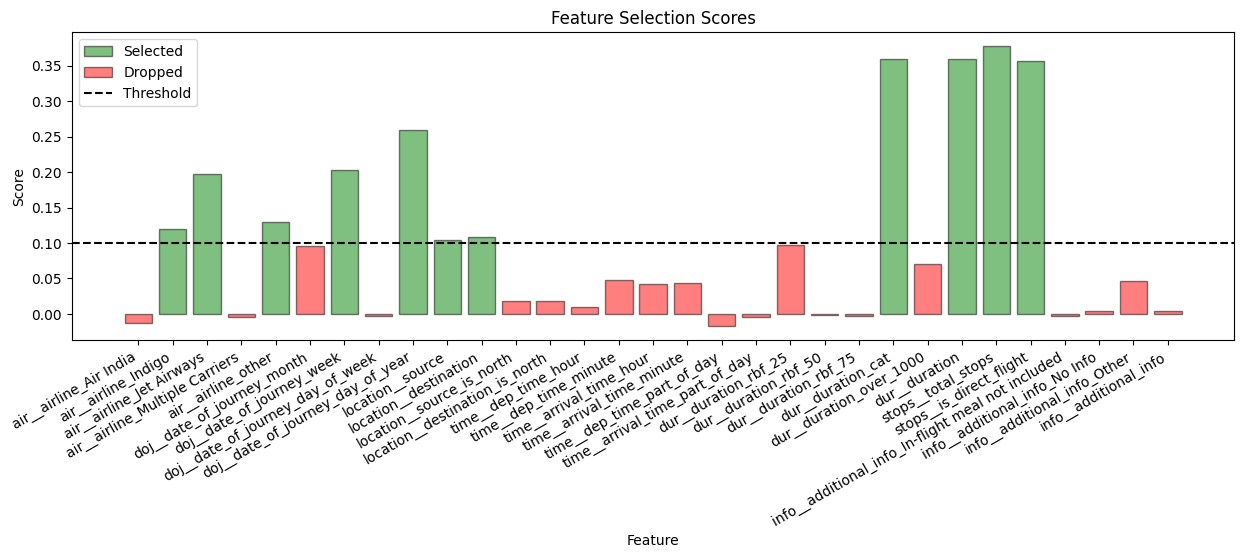

In [394]:
THRESHOLD = 0.1

selected_bar = None
dropped_bar = None
colors = ["red" if score < THRESHOLD else "green" for score in sorted_feat_imp.values()]


fig, ax = plt.subplots(figsize=(15, 4)) 

for i, (feature, score) in enumerate(sorted_feat_imp.items()):
	params = dict(
		x=i,
		height=score,
		edgecolor="black",
		alpha=0.5
	)
	
	if score < THRESHOLD:
		bar = ax.bar(
			color="red",
			**params
		)
		if not dropped_bar:
			dropped_bar = bar[0]
	else:
		bar = ax.bar(
			color="green",
			**params
		)
		if not selected_bar:
			selected_bar = bar[0]

thresh_line = ax.axhline(
	y=0.1,
	color="black",
	linestyle="--"
)

ax.set_xticks(
	ticks=range(len(sorted_feat_imp)),
	labels=list(sorted_feat_imp.keys()),
	rotation=30,
	ha="right"
)

ax.set(
	xlabel="Feature",
	ylabel="Score",
	title="Feature Selection Scores"
)

ax.legend(
	handles=[selected_bar, dropped_bar, thresh_line],
	labels=["Selected", "Dropped", "Threshold"],
	loc="upper left"
)

plt.show()